# Example: simple polynomial regression

This illustrates how I want to use the inversion package on the simplest linear example.

In [14]:
%matplotlib inline
from __future__ import print_function, division
from future.builtins import super, range
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import cPickle as pickle
from IPython.display import Math, display
from sklearn.base import BaseEstimator
from sklearn.cross_validation import KFold, train_test_split, cross_val_score
from fatiando import utils
from inversion import LinearModel, Newton, Damping, ScipyOptimizer, ACOR

In [2]:
class Regression(LinearModel, BaseEstimator):
    def __init__(self, degree):
        super().__init__()
        self.degree = degree
        
    def predict(self, x):
        return sum(self.p_[i]*(x**i) for i in range(self.degree + 1))
        
    def jacobian(self, x):
        A = np.empty((x.size, self.degree + 1))
        for i in range(self.degree + 1):
            A[:, i] = x**i
        return A
    
    def fit(self, x, y, **kwargs):
        super().fit(data=y, args=[x], **kwargs)
        return self
    
    @property
    def polynomial_(self):
        eq = ' + '.join([r'{:g}x^{{ {} }}'.format(self.p_[i], i) 
                         for i in range(self.degree + 1)])
        return Math(eq)

# Test on data

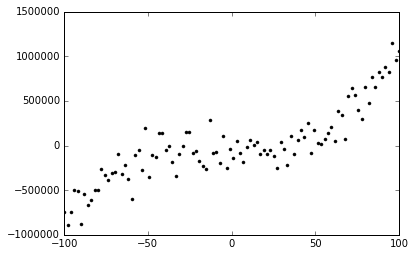

In [3]:
coefs = a, b, c, d = 1000, 10, 0, 1
n = 100
x = np.linspace(-100, 100, n)
y = a + b*x + c*x**2 + d*x**3
yo = utils.contaminate(y, 0.15, percent=True, seed=0)
plt.plot(x, yo, '.k')

[ -6.51901740e+04  -2.85679464e+02   1.94638432e+01   1.01180288e+00]


<IPython.core.display.Math object>

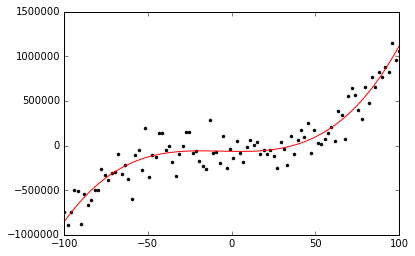

In [4]:
reg = Regression(3)
print(reg.fit(x, yo).p_)
display(reg.polynomial_)

plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

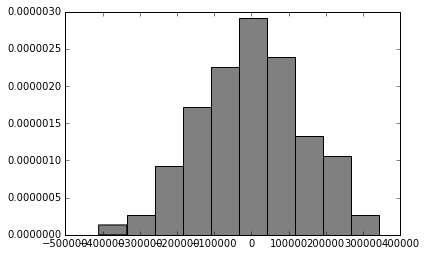

In [5]:
_ = plt.hist(yo - reg.predict(x), 10, normed=True, color='grey')

Can be pickled for use in parallel

In [6]:
pickle.loads(pickle.dumps(reg))

Regression(degree=3)

Can be a subclass of scikit-learn `BaseEstimator`:

<IPython.core.display.Math object>

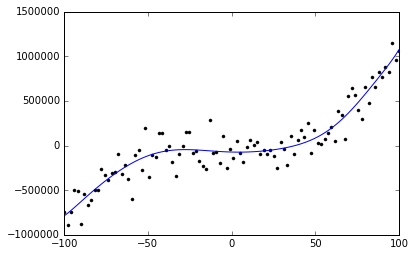

In [9]:
reg = Regression(3).set_params(degree=10)
display(reg.fit(x, yo).polynomial_)

plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-')

`config` still works but different.

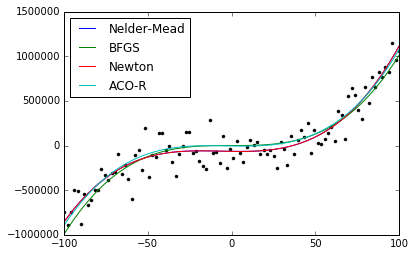

In [17]:
reg = Regression(3)
initial = np.ones(reg.degree + 1)
optimizers = {'Newton': Newton(initial=initial),
              'Nelder-Mead': ScipyOptimizer('Nelder-Mead', x0=initial),
              'BFGS': ScipyOptimizer('BFGS', x0=initial),
              'ACO-R': ACOR(bounds=[-5000, 5000], nparams=initial.size)}

plt.plot(x, yo, '.k')
for method in optimizers:
    reg.config(optimizer=optimizers[method])
    reg.fit(x, yo)
    plt.plot(x, reg.predict(x), '-', label=method)
plt.legend(loc='upper left')

# Cross-validation

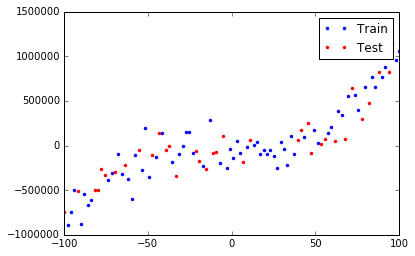

In [8]:
train, test = train_test_split(np.arange(x.size), train_size=0.65, random_state=42)

plt.plot(x[train], yo[train], '.b', label='Train')
plt.plot(x[test], yo[test], '.r', label='Test')
plt.legend()

Best degree: 3


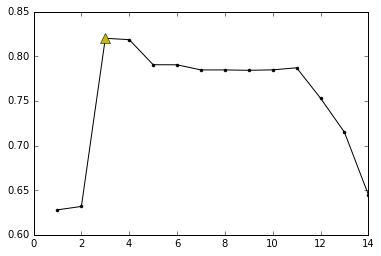

In [9]:
degrees = list(range(1, 15))
scores = [Regression(i).fit(x[train], yo[train]).score(x[test], yo[test])
          for i in degrees]

best = np.argmax(scores)
degree = degrees[best]

print('Best degree:', degree)
plt.plot(degrees, scores, '.-k')
plt.plot(degrees[best], scores[best], '^y', markersize=10)

<IPython.core.display.Math object>

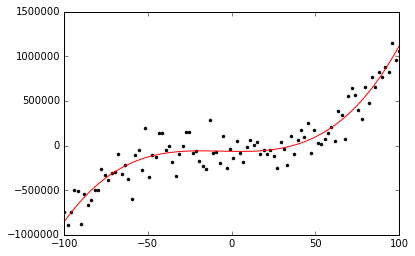

In [10]:
reg = Regression(degree).fit(x, yo)
display(reg.polynomial_)

plt.plot(x, yo, '.k')
plt.plot(x, reg.predict(x), '-r')

# KFold cross-validation

Best degree: 3


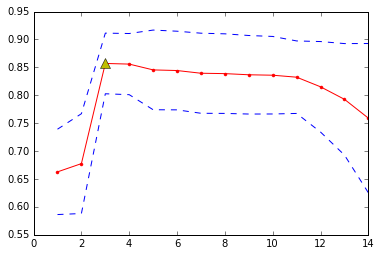

In [11]:
degrees = list(range(1, 15))
score_means = []
score_stds = []
kfold = KFold(yo.size, n_folds=3, shuffle=True, random_state=np.random.RandomState(42))
reg = Regression(3)

for degree in degrees:
    scores = [reg.set_params(degree=degree).fit(x[train], yo[train]).score(x[test], yo[test])
              for train, test in kfold]
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
best = np.argmax(score_means)
degree = degrees[best]
print('Best degree:', degree)

plt.plot(degrees, score_means, '.-r')
plt.plot(degrees[best], score_means[best], '^y', markersize=10)
plt.plot(degrees, np.array(score_means) + np.array(score_stds), '--b')
plt.plot(degrees, np.array(score_means) - np.array(score_stds), '--b')

# Re-weighted

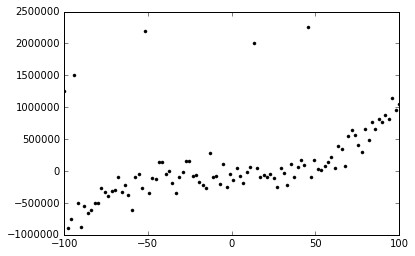

In [12]:
rand = np.random.RandomState(3)
yo2 = np.copy(yo)
yo2[rand.choice(yo.size, size=5)] += 2e6

plt.plot(x, yo2, '.k')

<IPython.core.display.Math object>

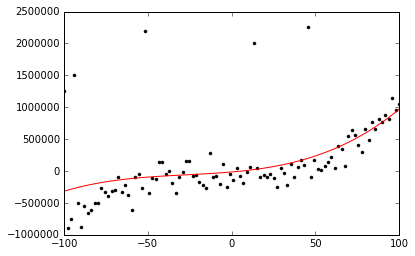

In [13]:
reg = Regression(3).fit(x, yo2)
display(reg.polynomial_)

plt.plot(x, yo2, '.k')
plt.plot(x, reg.predict(x), '-r')

<IPython.core.display.Math object>

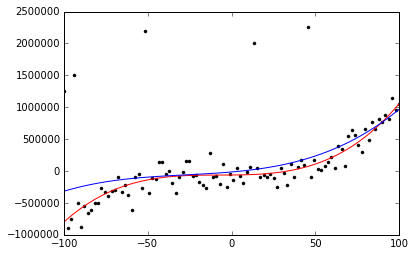

In [14]:
reg2 = Regression(3).fit_reweighted(x, yo2)
display(reg2.polynomial_)

plt.plot(x, yo2, '.k')
plt.plot(x, reg2.predict(x), '-r')
plt.plot(x, reg.predict(x), '-b')

## Regularization

In [15]:
class Ridge(Regression):
    def __init__(self, degree, damping=1e-5):
        super().__init__(degree)
        assert damping > 0
        self.damping = damping
    
    @property
    def damping(self):
        return self._damping
    
    @damping.setter
    def damping(self, damping):
        self._damping = damping
        regul = [[damping, Damping(self.degree + 1)]]
        self.config(regularization=regul)

Best mu: 1.17210229753e+22


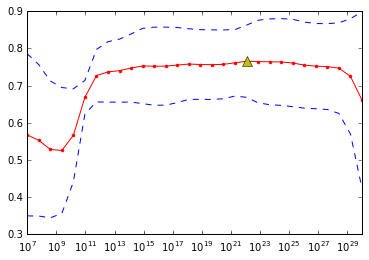

In [18]:
mus = np.logspace(7, 30, 30)
degree = 20
A = Ridge(degree).jacobian(x)

score_means = []
score_stds = []
kfold = KFold(yo.size, n_folds=3, shuffle=True, random_state=np.random.RandomState(42))
for mu in mus:
    scores = [Ridge(degree, damping=mu).fit(x[train], yo[train], jacobian=A[train]).score(x[test], yo[test])
              for train, test in kfold]
    score_means.append(np.mean(scores))
    score_stds.append(np.std(scores))
    
best = np.argmax(score_means)
mu = mus[best]
print('Best mu:', mu)

plt.plot(mus, score_means, '.-r')
plt.plot(mus[best], score_means[best], '^y', markersize=10)
plt.plot(mus, np.array(score_means) + np.array(score_stds), '--b')
plt.plot(mus, np.array(score_means) - np.array(score_stds), '--b')
plt.xscale('log')

<IPython.core.display.Math object>

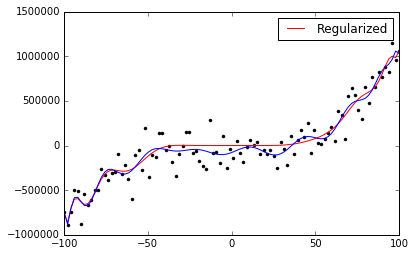

In [19]:
ridge = Ridge(damping=mu, degree=degree).fit(x, yo)
reg = Regression(degree).fit(x, yo)

display(ridge.polynomial_)

plt.plot(x, yo, '.k')
plt.plot(x, ridge.predict(x), '-r', label='Regularized')
plt.plot(x, reg.predict(x), '-b')
plt.legend()